# **5. 유사성과 모호성**

# 5.1 단어의 의미

- 단어와 의미의 관계 : 사람은 머릿속으로는 대부분 파란선 안쪽의 '의미'를 받아들이지만, 실제로 사용할 때는 파란선 바깥쪽의 '단어'를 매개체로 활용해 그 의미를 전달
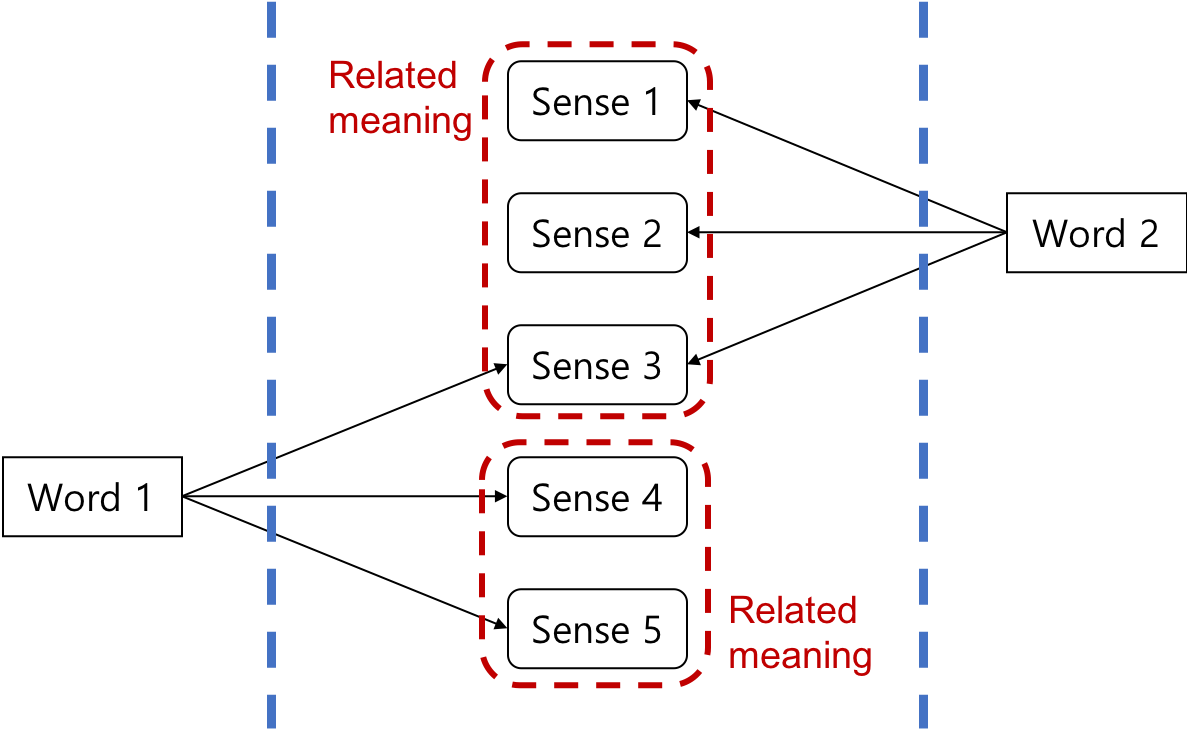
- 동형어homonym: 형태는 같으나 뜻이 서로 다른 단어(예: 차[마시다vs 달리다])
- 다의어: 한 형태의 단어가 여러 의미를 지니면서도 그 의미들이 서로 관련이 있는 뜻(예: 다리 [책상다리vs사람다리]) --> **단어 중의성 해소word-sense disambiguation(WSD)라는 방법을 통해 단어의 의미를 더 명확히 하는 과정이 필요**
- 동의어synonym:다른 형태이지만 의미가 같은 단어
- 상위어와 하위어 : 어휘 분류taxonomy에 따라 단어 간 관계 구조를 계층화
- 모호성 해소:  텍스트가 내포한 진짜 의미를 파악하는 과정이 필요--> 내포된 의미를 이해해야 제대로 된 자연어 처리를 진행할 수 있을 것 --> 단어 중의성 해소(WSD) 중요!!!



# 5.2   원핫 인코딩
- 단어를 컴퓨터가 인지할 수 있는 수치로 바꾸는 방법: 벡터로 표현
- 정의: 단 하나의 1과 나머지 수많은 0들로 표현된 인코딩 방식
- 문제점: 
1. 벡터의 차원이 너무 커짐 -> **희소벡터(sparse vector)**: 벡터간 연산시 결과값 0이 됨
2. **차원의 저주**: 차원이 높을수록 같은 정보를 표현하는데 불리함
  --> 차원을 축소하여 단어를 표현해야 함!

# 5.3   시소러스를 활용한 단어 의미 파악
- 시소러스 thesaurus: 어휘분류사전

> 워드넷 Wordnet
- 단어에 대한 상위어와 하위어 정보를 구축함으로써 유향 비순환 그래프(DAG) 형태로 이루어짐
- http://wordnetweb.princeton.edu/perl/webwn

# 5.3.3 WordNet을 활용한 단어간 유사도 비교
(코퍼스 없이 단어 간 유사도 구하는 방법)

In [55]:
!pip install nltk==3.2.5

In [56]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [57]:
#참고: https://frhyme.github.io/python-lib/nltk-wordnet/
from nltk.corpus import wordnet as wn

In [62]:
wn.synsets('people')

[Synset('people.n.01'),
 Synset('citizenry.n.01'),
 Synset('people.n.03'),
 Synset('multitude.n.03'),
 Synset('people.v.01'),
 Synset('people.v.02')]

In [60]:
wn.synsets('people')[0]

Synset('people.n.01')

In [6]:
#synset.hypernyms(): synset의 상위어들
wn.synsets('people')[0].hypernyms()

[Synset('group.n.01')]

In [63]:
#워드넷 특정 단어의 최상위 부모 노드까지 경로를 구하는 함수
def hypernyms(word):
    #현재 상태 return
    current_node = wn.synsets(word)[0]
    yield current_node
    
    while True:
        try:
            current_node = current_node.hypernyms()[0] #상위 노드 return
            yield current_node
        except IndexError:
            break

for h in hypernyms('policeman'):
    print(h)

Synset('policeman.n.01')
Synset('lawman.n.01')
Synset('defender.n.01')
Synset('preserver.n.03')
Synset('person.n.01')
Synset('causal_agent.n.01')
Synset('physical_entity.n.01')
Synset('entity.n.01')


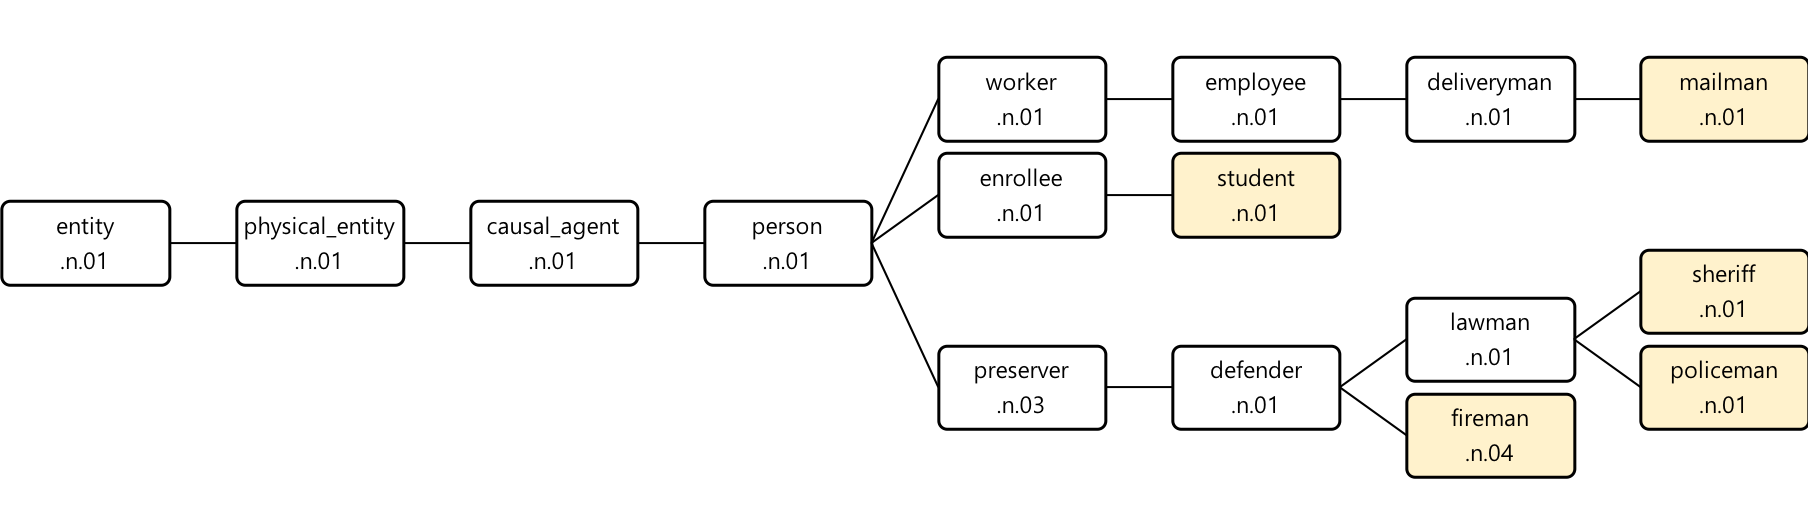

In [64]:
#단어 간 유사도 비교
def distance(word1, word2):
    word1_hypernyms = [h for h in hypernyms(word1)]
    
    for i, word2_hypernym in enumerate(hypernyms(word2)):
        try:
          # i는 word2의 상위로 가면서 word1에 존재하는 상위어가 있는지 찾는 로직
          # i = 2 일 경우 Synset('person.n.01')도 word1에 존재함. 그때의 index는 4 
          # 즉 2 + 4 => 6으로 거리를 산정하게 됨
            return i + word1_hypernyms.index(word2_hypernym) 
        except ValueError:
            continue

distance('sheriff', 'student')

6

In [9]:
# Code 설명
word1_hypernyms = [h for h in hypernyms('sheriff')]
word2_hypernyms = [h for h in hypernyms('student')]

In [10]:
word1_hypernyms

[Synset('sheriff.n.01'),
 Synset('lawman.n.01'),
 Synset('defender.n.01'),
 Synset('preserver.n.03'),
 Synset('person.n.01'),
 Synset('causal_agent.n.01'),
 Synset('physical_entity.n.01'),
 Synset('entity.n.01')]

In [11]:
word2_hypernyms

[Synset('student.n.01'),
 Synset('enrollee.n.01'),
 Synset('person.n.01'),
 Synset('causal_agent.n.01'),
 Synset('physical_entity.n.01'),
 Synset('entity.n.01')]

$$ similarity(w, w^\prime) = -\log distance(w, w^\prime) $$

#5.4 특징 : Feature
- 수치로 표현, 최대한 많은 샘플을 설명할 수 있어야 함
- 특징 벡터: 특징별 수치들을 모아 벡터로 표현한 것

> 단어의 특징 벡터를 구성하기 위한 가정
1. 의미가 비슷하면 쓰임새도 비슷할 것
2. 비슷한 문장 안에서 비슷한 역할로 사용될 것
3. 함께 나타나는 단어들이 유사할것

# 5.5 특징 추출하기: Term Frequency and Inverse Document Frequency (TF-IDF)

- TF-IDF : 출현빈도를 사용하여 어떤 단어 w가 문서 d내에서 얼마나 중요한지 나타내는 수치
- TF : Term Frequency의 약어로 단어의 문서 내에 출현한 횟수를 의미
- IDF: inverse document frequency의 약어, 그 단어가 출현한 숫자의 역수( 일반적으로 많이 쓰이는 단어의 경우에 페널티를 주는 개념)
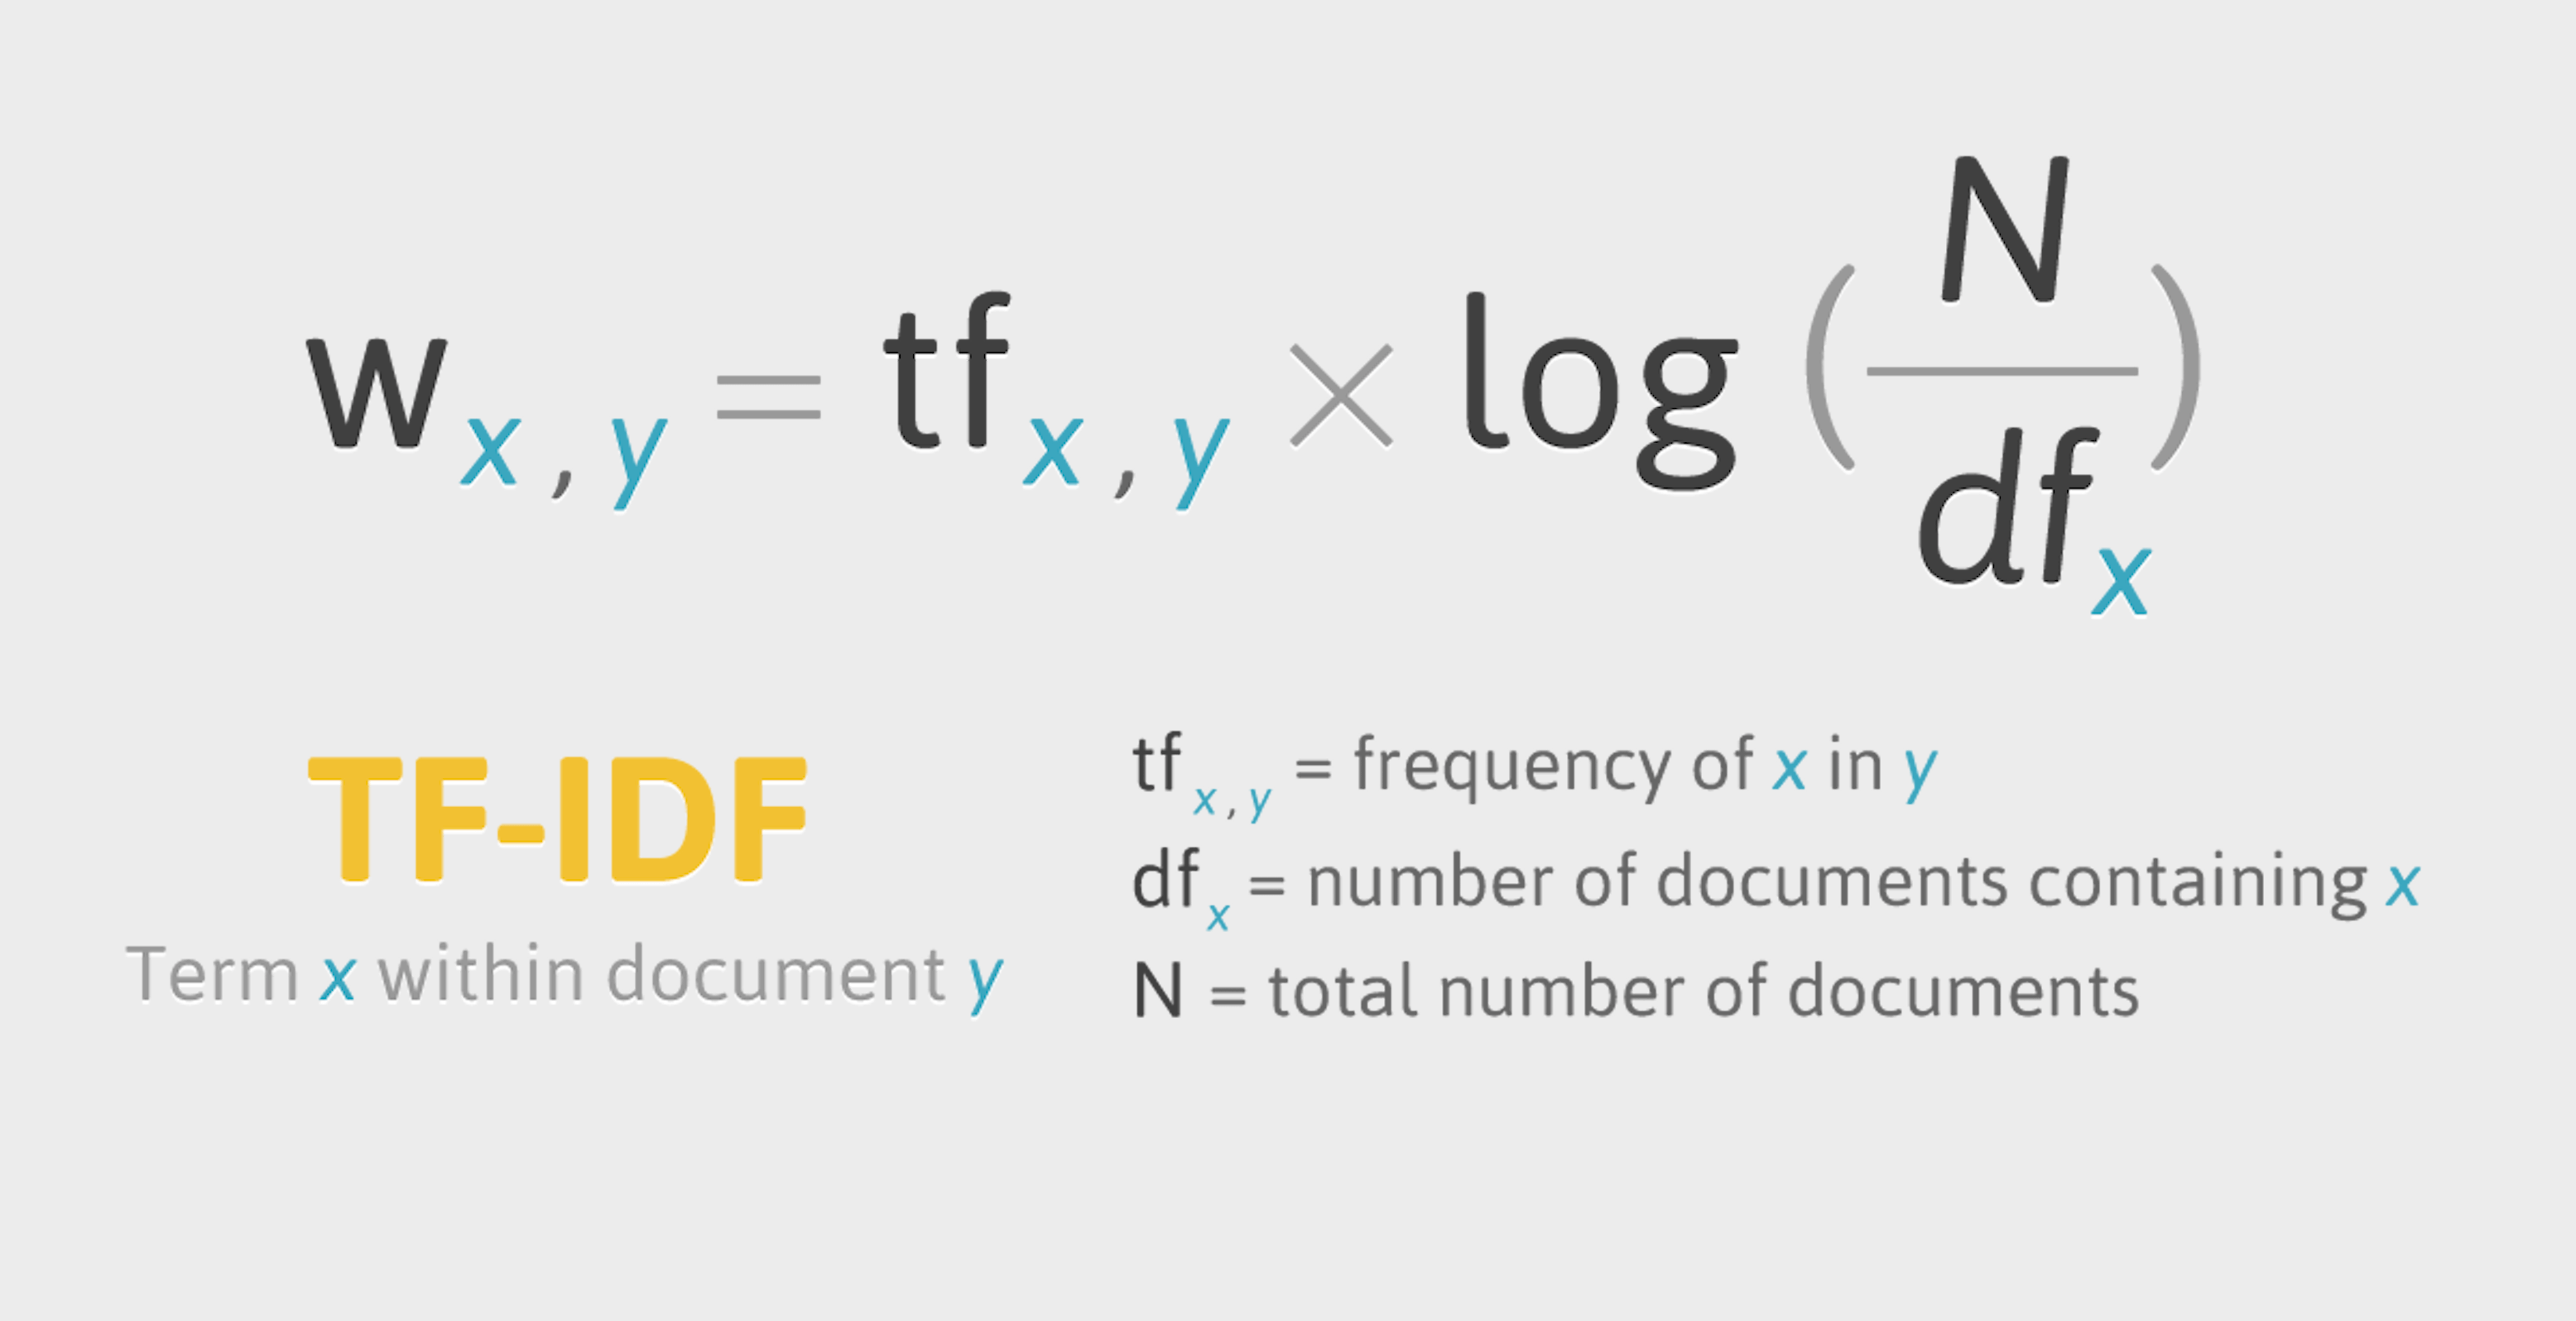

In [65]:
import pandas as pd

doc1 = '''
지능 지수 라는 말 들 어 보 셨 을 겁니다 . 여러분 의 지성 을 일컫 는 말 이 죠 . 그런데 심리 지수 란 건 뭘까요 ? 사람 들 이 특정 한 식 으로 행동 하 는 이유 에 대해 여러분 은 얼마나 알 고 계시 나요 ? 또 타인 이나 심지어 여러분 의 행동 을 예측 하 는 일 은 얼마나 잘 하 시 나요 ? 또 , 심리학 에 대해 갖춘 지식 중 에서 어느 정도 나 잘못 된 것 일까요 ? 심리학 에 관한 열 가지 신화 를 통해 잘못 된 것 들 을 알아보 도록 하 죠 . 여러분 은 한 번 쯤 들 어 보 셨 을 법 한 것 은 자신 들 의 심리학 에 대해 고려 할 때 , 거의 항상 남자 는 화성 에서 왔 고 , 여자 는 금성 에서 온 것 같 다고 합니다 . 하지만 실제로 남자 와 여자 는 얼마나 다른 걸까요 ? 이 를 알아보 기 위해 , 일단 남녀 사이 에 확실 하 게 차이 나 는 것 을 살펴보 고 심리학 적 인 성별 간 의 차이점 을 동일 한 척도 상 에서 대비 해 보 도록 하 겠 습니다 . 남자 와 여자 간 에 실제로 차이 나 는 능력 중 하나 는 그 들 이 공 을 얼마나 멀리 던질 수 있 느냐 하 는 것 입니다 . 여기 남자 들 의 데 이타 를 보 시 면 , 정상 분포 곡선 이 라는 걸 볼 수 있 습니다 . 남자 들 소수 는 정말 멀리 던지 고 , 남자 들 소수 는 멀리 던지 지 못하 지만 , 남자 들 대부분 은 평균 적 인 거리 를 던졌 습니다 . 여자 들 도 역시 비슷 한 분포 상태 를 보입니다 만 사실 남녀 사이 엔 커다란 차이 가 있 습니다 . 사실 , 평균 수준 의 남자 라면 모든 여성 중 대략 98 % 보다 더 멀리 던질 수 있 거든요 . 이 와 동일 하 게 표준 화 된 척도 상 에서 심리학 에서 말 하 는 성별 간 의 차이 를 살펴 봅시다 . 심리학자 라는 여러분 에게 말 하 길 남자 들 의 공간 지각 능력 이 여자 들 보다 뛰어나 다고 할 겁니다 . 예 를 들 어 , 지도 읽 는 능력 같 은 건데 , 맞 는 말 입니다 . 하지만 그 차이 의 정도 를 살펴봅시다 . 아주 작 죠 . 두 선 이 너무 근접 해서 거의 겹칠 정도 입니다 .
'''

doc2 = '''
최상 의 제시 유형 은 학습 자 에 좌우 되 는 것 이 아니 라 학습 해야 할 내용 에 따라 좌우 됩니다 . 예 를 들 어 여러분 이 운전 하 기 를 배울 때 실제로 몸 으로 체감 하 는 경험 없이 누군가 가 어떻게 할 지 이야기 하 는 것 을 듣 는 것 만 으로 배울 수 있 습니까 ? 연립 방정식 을 풀 어야 하 는데 종이 에 쓰 지 않 고 머리 속 에서 말 하 는 것 으로 풀 수 가 있 을까요 ? 또는 만일 여러분 이 체감 형식 의 학습 자 유형 이 라면 , 건축학 시험 을 해석 적 춤 을 이용 하 여 수정 할 수 있 을까요 ? 아니 죠 ! 배워야 할 내용 을 제시 된 유형 에 맞추 어야 합니다 , 당신 에게 맞추 는 게 아니 라요 . 여러분 들 상당수 가 " A " 급 의 우등 생 이 라는 걸 아 는데 , 조만간 중등 학력 인증 시험 ( GCSE ) 결과 를 받 게 되 시 겠 네요 . 그런데 , 만일 , 여러분 들 이 희망 했 던 성적 을 받 지 못하 게 된다 해도 여러분 들 의 학습 방식 을 탓 해서 는 안 되 는 겁니다 . 여러분 이 비난 할 수 있 는 한 가지 는 바로 유전자 입니다 . 이건 최근 에 런던 대학교 ( UCL ) 에서 수행 했 던 연구 결과 는 여러 학생 들 과 그 들 의 중등 학력 인증 시험 결과 사이 의 차이 중 58 % 는 유전 적 인 요인 으로 좁혀졌 습니다 . 매우 정밀 한 수치 처럼 들립니다 . 그러면 어떻게 알 수 있 을까요 ? 유전 적 요인 과 환경 적 요인 의 상대 적 기여 도 를 알 고 싶 을 때 우리 가 사용 할 수 있 는 방식 은 바로 쌍둥이 연구 입니다 . 일 란 성 쌍생아 의 경우 환경 적 요인 과 유전 적 요인 모두 를 100 % 똑같이 공유 하 게 되 지만 이란 성 쌍생아 의 경우 는 100 % 동일 한 환경 을 공유 하 지만 유전자 의 경우 여타 의 형제자매 들 처럼 50 % 만 공유 하 게 됩니다 . 따라서 일 란 성 쌍둥이 와 이란 성 쌍둥이 사이 의 인증 시험 결과 가 얼마나 비슷 한지 비교 해 보 고 여기 에 약간 의 수학 적 계산 을 더하 게 되 면 그 수행 능력 의 차이 중 어느 정도 가 환경 적 요인 의 탓 이 고 어느 정도 가 유전자 탓 인지 를 알 수 있 게 됩니다 .
'''

doc3 = '''
그러나 이 이야기 는 세 가지 이유 로 인해 신화 입니다 . 첫째 , 가장 중요 한 건 실험실 가운 은 흰색 이 아니 라 회색 이 었 다 라는 점 이 죠 . 둘째 , 참 여자 들 은 실험 하 기 전 에 와 참여 자 들 이 걱정 을 표현 할 때 마다 상기 시키 는 말 을 들 었 는데 , 전기 충격 이 고통 스럽 기 는 하 지만 , 치명 적 이 지 는 않 으며 실제로 영구 적 인 손상 을 남기 는 일 은 없 을 거 라는 것 이 었 습니다 . 셋째 , 참 여자 들 은 단지 가운 을 입 은 사람 이 시켜 전기 충격 을 주지 는 않 았 죠 . 실험 이 끝나 고 그 들 의 인터뷰 를 했 을 때 모든 참여 자 들 은 강한 신념 을 밝혔 는데 , ' 학습 과 처벌 ' 연구 가 과학 적 으로 가치 있 는 목적 을 수행 했 기 때문 에 비록 동료 참여 자 들 에게 가해진 순간 적 인 불편 함 에 반해서 과학 을 위해서 오래 남 을 성과 를 얻 을 것 이 라고 말 이 죠 . 그러 다 보 니 제 가 이야기 를 한 지 벌써 12 분 이 되 었 습니다 . 여러분 들 중 에 는 아마 거기 앉 아서 제 이야기 를 들으시는 동안 저 의 말투 와 몸짓 을 분석 하 면서 제 가 말 하 는 어떤 것 을 인지 해야 할까 해결 하 려고 하 셨 을 겁니다 , 제 가 진실 을 이야기 하 는 지 , 또는 거짓말 을 하 고 있 는 것 인지 말 이 죠 . 만일 그러 셨 다면 , 아마 지금 쯤 완전히 실패 하 셨 을 겁니다 . 왜냐하면 우리 모두 가 사람 이 말 하 는 패턴 과 몸짓 으로 도 거짓말 여부 를 알아내 는 것 이 가능 하 다고 생각 하 지만 , 오랜 세월 수백 회 에 걸쳐 행해진 실제 심리 검사 의 결과 를 보 면 우리 들 모두 는 , 심지어 경찰관 이나 탐정 들 을 포함 해서 도 기본 적 으로 몸짓 과 언어 적 패턴 으로 거짓말 을 탐지 하 는 것 은 운 에 맞 길 수 밖 에 는 없 는 것 입니다 . 흥미 롭 게 도 한 가지 예외 가 있 는데요 : 실종 된 친척 을 찾 아 달 라고 호소 하 는 TV 홍보 입니다 .
'''

In [66]:
# 특정 문서의 문서 내 단어들의 출현 빈도 세는 함수
# dictionary 형태로 저장
def get_term_frequency(document, word_dict=None):
    if word_dict is None:
        word_dict = {}
    words = document.split()

    for w in words:
        word_dict[w] = 1 + (0 if word_dict.get(w) is None else word_dict[w]) #단어사전에 이미 count 되어있다면 그 값에 +1

    return pd.Series(word_dict).sort_values(ascending=False)

get_term_frequency(doc1)

.     16
는     15
들     14
,     10
하     10
      ..
정상     1
면      1
이타     1
데      1
지능     1
Length: 186, dtype: int64

In [67]:
#문서들이 주어졌을 때, 각 단어가 몇 개의 문서에서 나타났는지 세는 함수
def get_document_frequency(documents):
    dicts = []
    vocab = set([])
    df = {}

    for d in documents:
        tf = get_term_frequency(d)
        dicts += [tf]                   #dicts[0]은 doc1의 TF, dicts[1]은 doc2의 TF가 저장됨
        vocab = vocab | set(tf.keys())  #vocab은 전체 문서의 중복 없는 단어사전의 역할 '|'는 합집합 역할
    
    for v in list(vocab):               #전체 문서의 단어사전의 단어가
        df[v] = 0                       #document frequency 초기화
        for dict_d in dicts:            #dicts의 doc1, doc2, doc3를 차례로 for문 수행
            if dict_d.get(v) is not None:   #vocab의 단어가 문서에 존재하면 +1 수행
                df[v] += 1

    return pd.Series(df).sort_values(ascending=False)

get_document_frequency([doc1, doc2])

라는     2
실제로    2
게      2
비슷     2
얼마나    2
      ..
대부분    1
중등     1
배울     1
자      1
거리     1
Length: 311, dtype: int64

In [68]:
#TF-IDF 계산하는 최종 함수 구현
def get_tfidf(docs):
    vocab = {}
    tfs = []
    for d in docs:
        vocab = get_term_frequency(d, vocab)  #vocab은 전체 {vocab : 빈도수}
        tfs += [get_term_frequency(d)]        #tfs[0]은 doc1의 TF, tfs[1]은 doc2의 TF가 저장됨
    df = get_document_frequency(docs)         #document frequency

    from operator import itemgetter
    import numpy as np

    stats = []
    for word, freq in vocab.items():
        tfidfs = []
        for idx in range(len(docs)):              
            if tfs[idx].get(word) is not None:    #문서 순서대로 word에 대한 dfidf 계산
                tfidfs += [tfs[idx][word] * np.log(len(docs) / df[word])] #tfidfs = [9, 7, 3] 이런 형식으로 저장
            else:
                tfidfs += [0]

        stats.append((word, freq, *tfidfs, max(tfidfs)))

    return pd.DataFrame(stats, columns=('word',
                                        'frequency',
                                        'doc1',
                                        'doc2',
                                        'doc3',
                                        'max')).sort_values('max', ascending=False)

get_tfidf([doc1, doc2, doc3])

,word,frequency,doc1,doc2,doc3,max
23,남자,9,9.887511,0.000000,0.000000,9.887511
37,요인,6,0.000000,6.591674,0.000000,6.591674
51,심리학,5,5.493061,0.000000,0.000000,5.493061
57,었,4,0.000000,0.000000,4.394449,4.394449
63,제,4,0.000000,0.000000,4.394449,4.394449
...,...,...,...,...,...,...
36,라는,6,0.000000,0.000000,0.000000,0.000000
33,중,6,0.000000,0.000000,0.000000,0.000000
30,습니다,7,0.000000,0.000000,0.000000,0.000000
29,보,7,0.000000,0.000000,0.000000,0.000000


In [69]:
# * 사용 test
test = [1,2,3]
print(*test)

1 2 3


#5.6 특징 벡터 만들기

# 5.6.1 Term-Frequency Matrix

In [17]:
def get_tf(docs):
    vocab = {}
    tfs = []
    for d in docs:
        vocab = get_term_frequency(d, vocab)
        tfs += [get_term_frequency(d)]

    from operator import itemgetter
    import numpy as np

    stats = []
    for word, freq in vocab.items():
        tf_v = []
        for idx in range(len(docs)):
            if tfs[idx].get(word) is not None:
                tf_v += [tfs[idx][word]]      #앞 예제의 TF-IDF 수식 대신에 단순하게 TF만 계산해서 데이터 입력
            else:
                tf_v += [0]
        stats.append((word, freq, *tf_v))
    
    return pd.DataFrame(stats, columns=('word',
                                        'frequency',
                                        'TF(w,d1)',
                                        'TF(w,d2)',
                                        'TF(w,d3)')).sort_values('frequency', ascending=False)  #TF(w, dn)이 특징벡터를 나타냄

get_tf([doc1, doc2, doc3])

,word,frequency,"TF(w,d1)","TF(w,d2)","TF(w,d3)"
0,는,47,15,14,18
1,을,39,8,10,21
2,.,36,16,10,10
3,하,33,10,9,14
4,이,32,8,8,16
...,...,...,...,...,...
273,스럽,1,0,0,1
274,치명,1,0,0,1
275,으며,1,0,0,1
276,영구,1,0,0,1


- 문서가 많아지면 지금보다 더 나은 특징 벡터를 구할 수 있지만, 지나치게 많을 경우 벡터의 차원이 커지게 된다. 결국 희소벡터의 문제가 생기게 됨
- 단순히 문서에서의 출현 횟수만으로 특징 벡터를 구성하다보니 많은 정보 유실

# 5.6.2 Based on Context Window (Co-occurrence)
- 윈도잉: 윈도우를 움직이며 그 안에 있는 유닛들의 정보를 취합하는 방법. 이때 사용되는 윈도우 => context window
- 동시 발생단어들을 활용하는 방법 **단어별로 윈도우 내에 속해 있는 이웃 단어들의 출현 빈도를 세어 행렬로 나타내는 것**(대부분의 경우 윈도우를 문장 내에만 적용함)
- 윈도우의 크기 : 하이퍼파라미터

In [70]:
# 데이터 셋을 못찾았음 ㅠㅠ
"""
with open('ted.aligned.ko.refined.tok.txt') as f:
    lines = [l.strip() for l in f.read().splitlines() if l.strip()]
with open('./test.txt') as f:
    lines = [l.strip() for l in f.read().splitlines() if l.strip()]
"""
lines = ['지능 지수 라는 말 들 어 보 셨 을 겁니다 ',
 '여러분 의 지성 을 일컫 는 말 이 죠 ',
 '그런데 심리 지수 란 건 뭘까요 ? 사람 들 이 특정 한 식 으로 행동 하 는 이유 에 대해 여러분 은 얼마나 알 고 계시 나요 ? 또 타인 이나 심지어 여러분 의 행동 을 예측 하 는 일 은 얼마나 잘 하 시 나요 ? 또 , 심리학 에 대해 갖춘 지식 중 에서 어느 정도 나 잘못 된 것 일까요 ? 심리학 에 관한 열 가지 신화 를 통해 잘못 된 것 들 을 알아보 도록 하 죠 ',
 '여러분 은 한 번 쯤 들 어 보 셨 을 법 한 것 은 자신 들 의 심리학 에 대해 고려 할 때 , 거의 항상 남자 는 화성 에서 왔 고 , 여자 는 금성 에서 온 것 같 다고 합니다 ',
 '하지만 실제로 남자 와 여자 는 얼마나 다른 걸까요 ? 이 를 알아보 기 위해 , 일단 남녀 사이 에 확실 하 게 차이 나 는 것 을 살펴보 고 심리학 적 인 성별 간 의 차이점 을 동일 한 척도 상 에서 대비 해 보 도록 하 겠 습니다 ',
 '남자 와 여자 간 에 실제로 차이 나 는 능력 중 하나 는 그 들 이 공 을 얼마나 멀리 던질 수 있 느냐 하 는 것 입니다 ',
 '여기 남자 들 의 데 이타 를 보 시 면 , 정상 분포 곡선 이 라는 걸 볼 수 있 습니다 ',
 '남자 들 소수 는 정말 멀리 던지 고 , 남자 들 소수 는 멀리 던지 지 못하 지만 , 남자 들 대부분 은 평균 적 인 거리 를 던졌 습니다 ',
 '여자 들 도 역시 비슷 한 분포 상태 를 보입니다 만 사실 남녀 사이 엔 커다란 차이 가 있 습니다 ',
 '사실 , 평균 수준 의 남자 라면 모든 여성 중 대략 98 % 보다 더 멀리 던질 수 있 거든요 ',
 '이 와 동일 하 게 표준 화 된 척도 상 에서 심리학 에서 말 하 는 성별 간 의 차이 를 살펴 봅시다 ',
 '심리학자 라는 여러분 에게 말 하 길 남자 들 의 공간 지각 능력 이 여자 들 보다 뛰어나 다고 할 겁니다 ',
 '예 를 들 어 , 지도 읽 는 능력 같 은 건데 , 맞 는 말 입니다 ',
 '하지만 그 차이 의 정도 를 살펴봅시다 ',
 '아주 작 죠 ',
 '두 선 이 너무 근접 해서 거의 겹칠 정도 입니다 ',
 '최상 의 제시 유형 은 학습 자 에 좌우 되 는 것 이 아니 라 학습 해야 할 내용 에 따라 좌우 됩니다 ',
 '예 를 들 어 여러분 이 운전 하 기 를 배울 때 실제로 몸 으로 체감 하 는 경험 없이 누군가 가 어떻게 할 지 이야기 하 는 것 을 듣 는 것 만 으로 배울 수 있 습니까 ? 연립 방정식 을 풀 어야 하 는데 종이 에 쓰 지 않 고 머리 속 에서 말 하 는 것 으로 풀 수 가 있 을까요 ? 또는 만일 여러분 이 체감 형식 의 학습 자 유형 이 라면 , 건축학 시험 을 해석 적 춤 을 이용 하 여 수정 할 수 있 을까요 ? 아니 죠 ! 배워야 할 내용 을 제시 된 유형 에 맞추 어야 합니다 , 당신 에게 맞추 는 게 아니 라요 ',
 '여러분 들 상당수 가 " A " 급 의 우등 생 이 라는 걸 아 는데 , 조만간 중등 학력 인증 시험 ( GCSE ) 결과 를 받 게 되 시 겠 네요 ',
 '그런데 , 만일 , 여러분 들 이 희망 했 던 성적 을 받 지 못하 게 된다 해도 여러분 들 의 학습 방식 을 탓 해서 는 안 되 는 겁니다 ',
 '여러분 이 비난 할 수 있 는 한 가지 는 바로 유전자 입니다 ',
 '이건 최근 에 런던 대학교 ( UCL ) 에서 수행 했 던 연구 결과 는 여러 학생 들 과 그 들 의 중등 학력 인증 시험 결과 사이 의 차이 중 58 % 는 유전 적 인 요인 으로 좁혀졌 습니다 ',
 '매우 정밀 한 수치 처럼 들립니다 ',
 '그러면 어떻게 알 수 있 을까요 ? 유전 적 요인 과 환경 적 요인 의 상대 적 기여 도 를 알 고 싶 을 때 우리 가 사용 할 수 있 는 방식 은 바로 쌍둥이 연구 입니다 ',
 '일 란 성 쌍생아 의 경우 환경 적 요인 과 유전 적 요인 모두 를 100 % 똑같이 공유 하 게 되 지만 이란 성 쌍생아 의 경우 는 100 % 동일 한 환경 을 공유 하 지만 유전자 의 경우 여타 의 형제자매 들 처럼 50 % 만 공유 하 게 됩니다 ',
 '따라서 일 란 성 쌍둥이 와 이란 성 쌍둥이 사이 의 인증 시험 결과 가 얼마나 비슷 한지 비교 해 보 고 여기 에 약간 의 수학 적 계산 을 더하 게 되 면 그 수행 능력 의 차이 중 어느 정도 가 환경 적 요인 의 탓 이 고 어느 정도 가 유전자 탓 인지 를 알 수 있 게 됩니다 ',
 '그러나 이 이야기 는 세 가지 이유 로 인해 신화 입니다 ',
 '첫째 , 가장 중요 한 건 실험실 가운 은 흰색 이 아니 라 회색 이 었 다 라는 점 이 죠 ',
 '둘째 , 참여자 들 은 실험 하 기 전 에 와 참여 자 들 이 걱정 을 표현 할 때 마다 상기 시키 는 말 을 들 었 는데 , 전기 충격 이 고통 스럽 기 는 하 지만 , 치명 적 이 지 는 않 으며 실제로 영구 적 인 손상 을 남기 는 일 은 없 을 거 라는 것 이 었 습니다 ',
 '셋째 , 참여자 들 은 단지 가운 을 입 은 사람 이 시켜 전기 충격 을 주지 는 않 았 죠 ',
 "실험 이 끝나 고 그 들 의 인터뷰 를 했 을 때 모든 참여 자 들 은 강한 신념 을 밝혔 는데 , ' 학습 과 처벌 ' 연구 가 과학 적 으로 가치 있 는 목적 을 수행 했 기 때문 에 비록 동료 참여 자 들 에게 가해진 순간 적 인 불편 함 에 반해서 과학 을 위해서 오래 남 을 성과 를 얻 을 것 이 라고 말 이 죠 ",
 '그러 다 보 니 제 가 이야기 를 한 지 벌써 12 분 이 되 었 습니다 ',
 '여러분 들 중 에 는 아마 거기 앉 아서 제 이야기 를 들으시는 동안 저 의 말투 와 몸짓 을 분석 하 면서 제 가 말 하 는 어떤 것 을 인지 해야 할까 해결 하 려고 하 셨 을 겁니다 , 제 가 진실 을 이야기 하 는 지 , 또는 거짓말 을 하 고 있 는 것 인지 말 이 죠 ',
 '만일 그러 셨 다면 , 아마 지금 쯤 완전히 실패 하 셨 을 겁니다',
 '왜냐하면 우리 모두 가 사람 이 말 하 는 패턴 과 몸짓 으로 도 거짓말 여부 를 알아내 는 것 이 가능 하 다고 생각 하 지만 , 오랜 세월 수백 회 에 걸쳐 행해진 실제 심리 검사 의 결과 를 보 면 우리 들 모두 는 , 심지어 경찰관 이나 탐정 들 을 포함 해서 도 기본 적 으로 몸짓 과 언어 적 패턴 으로 거짓말 을 탐지 하 는 것 은 운 에 맞 길 수 밖 에 는 없 는 것 입니다',
 '흥미 롭 게 도 한 가지 예외 가 있 는데요 : 실종 된 친척 을 찾 아 달 라고 호소 하 는 TV 홍보 입니다']

In [71]:
from collections import defaultdict

import pandas as pd

def get_context_counts(lines, w_size=2):
    co_dict = defaultdict(int)                # 처음 키를 지정할 때 값을 주지 않으면 default 값 지정 '0'
    
    for line in lines:
      words = line.split()
        
      for i, w in enumerate(words):
          for c in words[i - w_size:i + w_size]:
              if w != c:
                  co_dict[(w, c)] += 1
            
    return pd.Series(co_dict, dtype='int').sort_values(ascending=False) #sort_values 추가

co_dict = get_context_counts(lines)
co_dict

는   하     13
하   는     13
것   는     11
는   것     10
있   수     10
          ..
더하  게      1
    을      1
    계산     1
을   더하     1
라는  지능     1
Length: 2758, dtype: int64

In [72]:
tfs = get_term_frequency(' '.join(lines))
tfs

는       47
을       39
하       33
이       32
들       31
        ..
사용       1
똑같이      1
여타       1
형제자매     1
지능       1
Length: 436, dtype: int64

In [73]:
# 상관성을 Matrix로 표현
def co_occurrence(co_dict, vocab):
    data = []
    
    for word1 in vocab:
        row = []
        
        for word2 in vocab:
            try:
                count = co_dict[(word1, word2)]
            except KeyError:
                count = 0
            row.append(count)
            
        data.append(row)
    
    return pd.DataFrame(data, index=vocab, columns=vocab)
        
co = co_occurrence(co_dict, tfs.index[:1000])
co

,는,을,하,이,들,의,",",를,에,것,적,은,있,가,여러분,수,말,한,고,게,할,?,남자,으로,죠,입니다,에서,차이,지,보,습니다,과,라는,중,요인,되,와,정도,%,겁니다,...,계산,더하,그러나,세,로,인해,첫째,가장,중요,실험실,흰색,회색,점,둘째,전,걱정,표현,비교,한지,따라서,수치,대학교,UCL,여러,학생,58,좁혀졌,매우,정밀,들립니다,50,그러면,상대,기여,싶,사용,똑같이,여타,형제자매,지능
는,0,4,13,2,3,1,3,1,2,10,0,0,4,0,0,2,7,2,1,1,0,0,1,0,0,0,0,2,2,0,0,0,0,2,0,2,1,0,1,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
을,4,0,3,2,3,3,0,2,0,5,2,1,0,1,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,3,...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
하,13,7,0,3,0,0,0,0,1,0,0,1,1,1,0,0,5,0,1,4,0,0,0,2,1,0,2,0,1,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
이,3,1,0,0,4,1,0,1,0,4,1,2,0,1,3,0,4,0,1,0,0,1,0,0,4,0,0,0,1,0,0,0,4,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
들,1,3,0,5,0,7,5,2,0,1,0,4,0,0,2,0,2,0,1,0,0,1,4,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
사용,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
똑같이,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
여타,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
형제자매,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [74]:
import torch

torch.save(co, 'co.pth')

In [75]:
co = torch.load('co.pth')
co

,는,을,하,이,들,의,",",를,에,것,적,은,있,가,여러분,수,말,한,고,게,할,?,남자,으로,죠,입니다,에서,차이,지,보,습니다,과,라는,중,요인,되,와,정도,%,겁니다,...,계산,더하,그러나,세,로,인해,첫째,가장,중요,실험실,흰색,회색,점,둘째,전,걱정,표현,비교,한지,따라서,수치,대학교,UCL,여러,학생,58,좁혀졌,매우,정밀,들립니다,50,그러면,상대,기여,싶,사용,똑같이,여타,형제자매,지능
는,0,4,13,2,3,1,3,1,2,10,0,0,4,0,0,2,7,2,1,1,0,0,1,0,0,0,0,2,2,0,0,0,0,2,0,2,1,0,1,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
을,4,0,3,2,3,3,0,2,0,5,2,1,0,1,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,3,...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
하,13,7,0,3,0,0,0,0,1,0,0,1,1,1,0,0,5,0,1,4,0,0,0,2,1,0,2,0,1,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
이,3,1,0,0,4,1,0,1,0,4,1,2,0,1,3,0,4,0,1,0,0,1,0,0,4,0,0,0,1,0,0,0,4,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
들,1,3,0,5,0,7,5,2,0,1,0,4,0,0,2,0,2,0,1,0,0,1,4,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
사용,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
똑같이,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
여타,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
형제자매,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


#5.7 벡터 유사도: Similarity Measures

In [ ]:
import torch

In [24]:
# L1 distance : 맨해튼 거리

def get_l1_distance(x1, x2):
    return ((x1 - x2).abs()).sum()

$$
\text{d}_{\text{L1}}(w,v)=\sum_{i=1}^d{|w_i-v_i|},\text{ where }w,v\in\mathbb{R}^d.
$$

In [36]:
# L2 distance : 유클리디안 거리
# 제곱 : **2, 루트: **.5

def get_l2_distance(x1, x2):
    return ((x1 - x2)**2).sum()**.5

$$
\text{d}_{\text{L2}}(w,v)=\sqrt{\sum_{i=1}^d{(w_i-v_i)^2}},\text{ where }w,v\in\mathbb{R}^d.
$$

In [37]:
# infinity Norm: 차원 별 값의 차이 중 가장 큰 값

def get_infinity_distance(x1, x2):
    return ((x1 - x2).abs()).max()

$$
d_{\infty}(w,v)=\max(|w_1-v_1|,|w_2-v_2|,\cdots,|w_d-v_d|),\text{ where }w,v\in\mathbb{R}^d
$$

In [38]:
# 코사인 유사도: 두 벡터 사이의 방향과 크기를 모두 고려하는 방법
# 결과가 1에 가까울수록 방향은 일치하고, 0에 가까울수록 직교이며, -1에 가까울수록 반대방향
# 자연어 처리에서 가장 널리 쓰이는 유사도 측정 방법!

def get_cosine_similarity(x1, x2):
    return (x1 * x2).sum() / ((x1**2).sum()**.5 * (x2**2).sum()**.5)

$$
\begin{aligned}
\text{sim}_{\text{cos}}(w,v)&=\overbrace{\frac{w\cdot v}{|w||v|}}^{\text{dot product}}
=\overbrace{\frac{w}{|w|}}^{\text{unit vector}}\cdot\frac{v}{|v|} \\
&=\frac{\sum_{i=1}^{d}{w_iv_i}}{\sqrt{\sum_{i=1}^d{w_i^2}}\sqrt{\sum_{i=1}^d{v_i^2}}} \\
\text{where }&w,v\in\mathbb{R}^d
\end{aligned}
$$

In [39]:
# 자카드 유사도: 두 집합 간의 유사도를 구하는 방법
# 수식의 윗변에 두집합의 교집합이 있고, 이를 밑변에서 두 집합의 합집합의 크기로 나눔

def get_jaccard_similarity(x1, x2):
    return torch.stack([x1, x2]).min(dim=0)[0].sum() / torch.stack([x1, x2]).max(dim=0)[0].sum()

$$
\begin{aligned}
\text{sim}_{\text{jaccard}}(w,v)&=\frac{|w \cap v|}{|w \cup v|} \\
&=\frac{|w \cap v|}{|w|+|v|-|w \cap v|} \\
&\approx\frac{\sum_{i=1}^d{\min(w_i,v_i)}}{\sum_{i=1}^d{\max(w_i,v_i)}} \\
\text{where }&w,v\in\mathbb{R}^d.
\end{aligned}
$$

In [76]:
#문서 간 유사도 구하기
def get_nearest(query, dataframe, metric, top_k, ascending=True):
    vector = torch.FloatTensor(dataframe.loc[query].values)
    distances = dataframe.apply(lambda x: metric(vector, torch.FloatTensor(x.values)), axis=1)
    top_distances = distances.sort_values(ascending=ascending)[:top_k]

    print(', '.join([f'{k} ({v:.1f})' for k, v in top_distances.items()]))

In [77]:
#위에서 만든 co dataframe과 '우리'라는 단어간의 유사도 측정
print('L1 distance:')
get_nearest('우리', co, get_l1_distance, 30)
print('\nL2 distance:')
get_nearest('우리', co, get_l2_distance, 30)
print('\nInfinity distance:')
get_nearest('우리', co, get_infinity_distance, 30)
print('\nCosine similarity:')
get_nearest('우리', co, get_cosine_similarity, 30, ascending=False)
print('\nJaccard similarity:')
get_nearest('우리', co, get_jaccard_similarity, 30, ascending=False)

L1 distance:
우리 (0.0), 상당수 (5.0), 진실 (5.0), 공 (5.0), 포함 (5.0), 걱정 (5.0), 심리학자 (6.0), 둘째 (6.0), 예 (6.0), 첫째 (6.0), 하지만 (6.0), 그런데 (6.0), 셋째 (6.0), 그러 (6.0), 최상 (6.0), 흥미 (6.0), 롭 (6.0), 왜냐하면 (6.0), 이건 (6.0), 최근 (6.0), 선 (6.0), 지능 (6.0), 그러나 (6.0), 따라서 (6.0), 정밀 (6.0), 매우 (6.0), 두 (6.0), 그러면 (6.0), 강한 (7.0), 신념 (7.0)

L2 distance:
우리 (0.0), 공 (2.2), 상당수 (2.2), 포함 (2.2), 걱정 (2.2), 진실 (2.2), 흥미 (2.4), 최상 (2.4), 그러 (2.4), 선 (2.4), 최근 (2.4), 그런데 (2.4), 왜냐하면 (2.4), 이건 (2.4), 하지만 (2.4), 첫째 (2.4), 예 (2.4), 둘째 (2.4), 롭 (2.4), 셋째 (2.4), 지능 (2.4), 그러나 (2.4), 정밀 (2.4), 매우 (2.4), 심리학자 (2.4), 두 (2.4), 그러면 (2.4), 따라서 (2.4), 찾 (2.6), 특정 (2.6)

Infinity distance:
우리 (0.0), 지식 (1.0), 끝나 (1.0), 았 (1.0), 주지 (1.0), 시켜 (1.0), 입 (1.0), 단지 (1.0), 셋째 (1.0), 거 (1.0), 남기 (1.0), 손상 (1.0), 영구 (1.0), 으며 (1.0), 치명 (1.0), 스럽 (1.0), 가치 (1.0), 너무 (1.0), 목적 (1.0), 비록 (1.0), 들으시는 (1.0), 아서 (1.0), 앉 (1.0), 거기 (1.0), 인터뷰 (1.0), 분 (1.0), 강한 (1.0), 밝혔 (1.0), 달 (1.0), 찾 (1.0)

Cosine similarity:
지능 (nan), 진실 (0.5), 선 (nan), 두 

#5.8 단어 중의성 해소(WSD)

#5.8.1 시소러스 기반 중의성 해소(Thesaurus Based Method: Lesk Algorithm)
- 사전 기반 중의성 해소
- 중의성을 해소하고자 하는 단어에 대해 사전(주로 워드넷)의 의미별 설명가 주어진 문장 내에 등장한 단어에서 의미별 설명 사이의 유사도를 구함
- 문장 내 단어들의 의미별 설명과 가장 유사도가 높은 의미를 선택함


In [42]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [78]:
from nltk.corpus import wordnet as wn

for ss in wn.synsets('bass'):
    print(ss, ss.definition())

Synset('bass.n.01') the lowest part of the musical range
Synset('bass.n.02') the lowest part in polyphonic music
Synset('bass.n.03') an adult male singer with the lowest voice
Synset('sea_bass.n.01') the lean flesh of a saltwater fish of the family Serranidae
Synset('freshwater_bass.n.01') any of various North American freshwater fish with lean flesh (especially of the genus Micropterus)
Synset('bass.n.06') the lowest adult male singing voice
Synset('bass.n.07') the member with the lowest range of a family of musical instruments
Synset('bass.n.08') nontechnical name for any of numerous edible marine and freshwater spiny-finned fishes
Synset('bass.s.01') having or denoting a low vocal or instrumental range


In [44]:
def lesk(sentence, word):
    from nltk.wsd import lesk

    best_synset = lesk(sentence.split(), word)
    print(best_synset, best_synset.definition())

In [79]:
sentence = 'I went fishing last weekend and I got a bass and cooked it'
word = 'bass'
lesk(sentence, word)

Synset('sea_bass.n.01') the lean flesh of a saltwater fish of the family Serranidae


In [80]:
sentence = 'I love the music from the speaker which has strong beat and bass'
word = 'bass'
lesk(sentence, word)

Synset('bass.n.02') the lowest part in polyphonic music


In [81]:
sentence = 'I think the bass is more important than guitar'
word = 'bass'
lesk(sentence, word)

Synset('sea_bass.n.01') the lean flesh of a saltwater fish of the family Serranidae


> 레스크 알고리즘의 장단점
- 장점: 워드넷과 같이 잘 분류된 사전이 있다면, 쉽고 빠르게 중의성 해소 문제를 해결할 수 있을 것
- 단점 : 사전의 단어 및 의미에 관한 설명에 크게 의존하게 되고, 설명이 부실하거나 주어진 문장에 큰 특징이 없을 경우 단어 중의성 해소 능력이 크게 떨어짐. 그리고 워드넷이 모든 언어에 대해 존재하지 않으므로, 사전이 존재하지 않는 언어에 대해서는 수행이 어려움


#5.9 선택 선호도 Selectional preference
의미 : 각 단어는 문장내 주변 단어들에 따라 의미가 정해진다 


#5.9.1 선택 선호도 강도
- 단어와 단어 사이의 관계가 좀 더 특별한 경우 수치화하여 나타냄
- 분포의 차이가 크면 클 수록 해당 술어는 더 강력한 선택 선호도를 갖는다(예; **사용하다** -> 음식, 사람, 동물,**공구**, 장소)
- 쿨백-라이블러 발산(KLD)을 사용하여 정의함

#5.9.2 선택 관련도
- 매우 일반적인 동사에 대해서는 대부분의 클래스가 사전확률 분포와 여전히 비슷하게 나타남(선택 선호도 강도가 0 에 가까움)
- 선택 선호도 강도가 낮아서, 해당 술어는 클래스에 대한 선택적 선호 강도가 낮음에도 불구하고, 특정 클래스만 유독 술어에 영향을 받아서 윗변이 커질수록 선택 관련도의 수치도 커짐
- 즉, 해당 동사와 붙어서 좀 더 자주 출현하는 목적어가 있다면 선택 관련도는 매우 높게 나타날 것

#5.9.3 선택 선호도와 WSD
- 만약단어가 어떤 클래스에 속하는지 미리 알고 있다면 단어들의 출현 빈도를 세어 클래스의 확률 분포를 추정(사전 정의된 지식 or 데이터셋 필요)

#5.9.4 워드넷 기반의 선택선호도
- 술어 w와 표제어 h가 주어졌을 때 h의클래스 c를 추정한 c_hat을구할 수 있음

#5.9.5 유사어휘를 통한 선택 선호도 평가
- 유사어휘 : 두 개의 단어가 인위적으로 합성되어 만들어진 단어

# 5.9.6 유사도 기반의 선택 선호도- Similarity Based Method [Erk et al.2007]
- 단어간 유사도를 통해 시소러스에 의존하지 않고 데이터를 기반으로 간단하게 선택 선호도를 구하는 방법

In [48]:
!export MACOSX_DEPLOYMENT_TARGET=10.10

In [49]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 460kB 43.7MB/s 
     |████████████████████████████████| 92kB 9.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [82]:
# 코퍼스를 받아 문장 내에서 동사(VV)와 명사(NNG)를 찾아 Seen 함수를 구성함
from konlpy.tag import Kkma

with open('test.txt') as f:
    lines = [l.strip() for l in f.read().splitlines() if l.strip()]

def count_seen_headwords(lines, predicate='VV', headword='NNG'):
    tagger = Kkma()
    seen_dict = {}
    
    for line in lines:
        pos_result = tagger.pos(line)
        
        word_h = None
        word_p = None
        for word, pos in pos_result:                # 단어, 품사
            if pos == predicate or pos[:3] == predicate + '+':  #품사가 동사(VV)인 경우
                word_p = word
                break
            if pos == headword:                                 #품사가 명사(NNG)인 경우
                word_h = word
        
        if word_h is not None and word_p is not None:
            seen_dict[word_p] = [word_h] + ([] if seen_dict.get(word_p) is None else seen_dict[word_p])
            
    return seen_dict

seen_headwords = count_seen_headwords(lines)
seen_headwords

{'가': ['예외', '모두'],
 '걸': ['실패'],
 '까': ['무엇'],
 '끝': ['이'],
 '늘': ['이야기', '결과', '일'],
 '던지': ['여성'],
 '되': ['하', '좌우'],
 '드': ['만일'],
 '들': ['참여자', '참여자', '예', '예', '남자', '여자', '남자', '남자'],
 '들리': ['수치'],
 '살펴보': ['정도'],
 '알': ['이'],
 '어': ['들', '들'],
 '오': ['남자'],
 '저': ['날'],
 '하': ['비난', '근접']}

In [83]:
import torch
torch.save(seen_headwords, 'seen_headwords.pth')

In [84]:
seen_headwords = torch.load('seen_headwords.pth')
seen_headwords

{'가': ['예외', '모두'],
 '걸': ['실패'],
 '까': ['무엇'],
 '끝': ['이'],
 '늘': ['이야기', '결과', '일'],
 '던지': ['여성'],
 '되': ['하', '좌우'],
 '드': ['만일'],
 '들': ['참여자', '참여자', '예', '예', '남자', '여자', '남자', '남자'],
 '들리': ['수치'],
 '살펴보': ['정도'],
 '알': ['이'],
 '어': ['들', '들'],
 '오': ['남자'],
 '저': ['날'],
 '하': ['비난', '근접']}

In [85]:
sorted(list(seen_headwords))

['가',
 '걸',
 '까',
 '끝',
 '늘',
 '던지',
 '되',
 '드',
 '들',
 '들리',
 '살펴보',
 '알',
 '어',
 '오',
 '저',
 '하']

$$
(w,h,R),\text{ where }R\text{ is a relationship, such as verb-object}.
$$

$$
A_R(w,h_0)=\sum_{h\in\text{Seen}_R(w)}{\text{sim}(h_0,h)\cdot \phi_R(w,h)}
$$

In [54]:
#단어 사이의 유사도를 구하기 위해 이전에 구성한 특징 벡터들을 담은 pandas df을 받는다.
def get_selectional_association(predicate, headword, lines, dataframe, metric):
    v1 = torch.FloatTensor(dataframe.loc[headword].values)
    seens = seen_headwords[predicate]
    
    total = 0
    for seen in seens:
        try:
            v2 = torch.FloatTensor(dataframe.loc[seen].values)
            total += metric(v1, v2)
        except:
            pass
        
    return total

In [ ]:
co = torch.load('co.pth')

def wsd(predicate, headwords):
    selectional_associations = []
    for h in headwords:
        selectional_associations += [get_selectional_association(predicate, h, lines, co, get_cosine_similarity)]

    print(selectional_associations)

In [ ]:
wsd('가', ['모두', '사람', '여성'])

[tensor(1.1741), tensor(0.3559), tensor(0.)]
